## RNN своими руками

Ноутбук сделан по мотивам [ноутбука из документации PyTorch](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

In [1]:
%matplotlib inline


В этом ноутбуке при помощи классической RNN мы будем решать задачу классификации: будем определять, к какому языку относится то или иное имя.

Загрузим [архив с данными](https://disk.yandex.ru/d/o1v3K9sCG5JN5w) для задачи и распакуем его.

In [3]:
!wget https://disk.yandex.ru/d/o1v3K9sCG5JN5w

--2024-01-16 16:00:50--  https://disk.yandex.ru/d/o1v3K9sCG5JN5w
Resolving disk.yandex.ru (disk.yandex.ru)... 87.250.250.50, 2a02:6b8::2:50
Connecting to disk.yandex.ru (disk.yandex.ru)|87.250.250.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31528 (31K) [text/html]
Saving to: ‘o1v3K9sCG5JN5w’

o1v3K9sCG5JN5w      100%[===================>]  30.79K   110KB/s    in 0.3s    

2024-01-16 16:00:52 (110 KB/s) - ‘o1v3K9sCG5JN5w’ saved [31528/31528]



In [5]:
from zipfile import ZipFile

zip = ZipFile('names.zip')
zip.extractall()

В следующих трех ячейках происходит доступ к данным в файлах и их обработка.

In [6]:
from io import open
import glob
import os

def findFiles(path):
    return glob.glob(path)

print(findFiles('names/*.txt'))

['names/Vietnamese.txt', 'names/Russian.txt', 'names/Korean.txt', 'names/Arabic.txt', 'names/Czech.txt', 'names/Polish.txt', 'names/Japanese.txt', 'names/Italian.txt', 'names/Chinese.txt', 'names/Portuguese.txt', 'names/Dutch.txt', 'names/Spanish.txt', 'names/English.txt', 'names/Irish.txt', 'names/French.txt', 'names/German.txt', 'names/Scottish.txt', 'names/Greek.txt']


In [7]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Перевод Unicode в Ascii https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [19]:
n_letters

57

In [8]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Теперь у нас есть:

* Словарь `category_lines` - ключом является язык (записанный на английском языке с большой буквы), а значениями - имена из этого языка

* `all_categories` - список всех имеющихся языков

* `n_categories` - число языков.




In [10]:
category_lines.keys()

dict_keys(['Vietnamese', 'Russian', 'Korean', 'Arabic', 'Czech', 'Polish', 'Japanese', 'Italian', 'Chinese', 'Portuguese', 'Dutch', 'Spanish', 'English', 'Irish', 'French', 'German', 'Scottish', 'Greek'])

In [11]:
category_lines['Russian'][:10]

['Ababko',
 'Abaev',
 'Abagyan',
 'Abaidulin',
 'Abaidullin',
 'Abaimoff',
 'Abaimov',
 'Abakeliya',
 'Abakovsky',
 'Abakshin']

## Задание

Какое имя находится вторым по счету в списке французских имен?

In [13]:
category_lines['French'][1]

'Abraham'

In [16]:
len(category_lines)

18

### Переведем имена в тензоры

Закодируем каждую букву при помощи one-hot кодирования.
Например,
``"b" = <0 1 0 0 0 ...>`` и так далее.

Тогда слово - это будет матрица, где в каждой строке находится one-hot вектор букв слова. Матрица будет размера ``<line_length x 1 x n_letters>``.

Размерность `1` мнимая, она нужна нам, так как PyTorch работает с объектами по батчам - мы будем использовать "батчи из одного объекта".



In [14]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [15]:
print(lineToTensor('Jones'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

## Создание RNN

Опишем архитектуру класического RNN-блока:

Первый линейный слой (обновление скрытого состояния ячейки):

* На вход в первый линейный (полносвязный) слой поступает вектор размера `input_size + hidden_size`, где `input_size` - длина one-hot вектора буквы, а `hidden_size` - количество нейронов в скрытом состоянии ячейки: на вход слою подается сконкатенированный вектор слова `x` и вектор скрытого состояния `a`.

* На выходе из слоя получаем `hidden_size` число нейронов

После первого линейного слоя в классической RNN применяется функция активации tanh - здесь для простоты обойдемся без нее. Затем следует второй линейный слой.

Второй линейный слой (получение прогноза):

* На вход поступает `n_hidden` число нейронов, на выход - `output_size` нейронов (равное числу языков в данных).

* После выхода из этого слоя применяется функция активации `softmax`. Так как наш лосс будет [NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html), то лучше использовать активацию `LogSoftmax`.


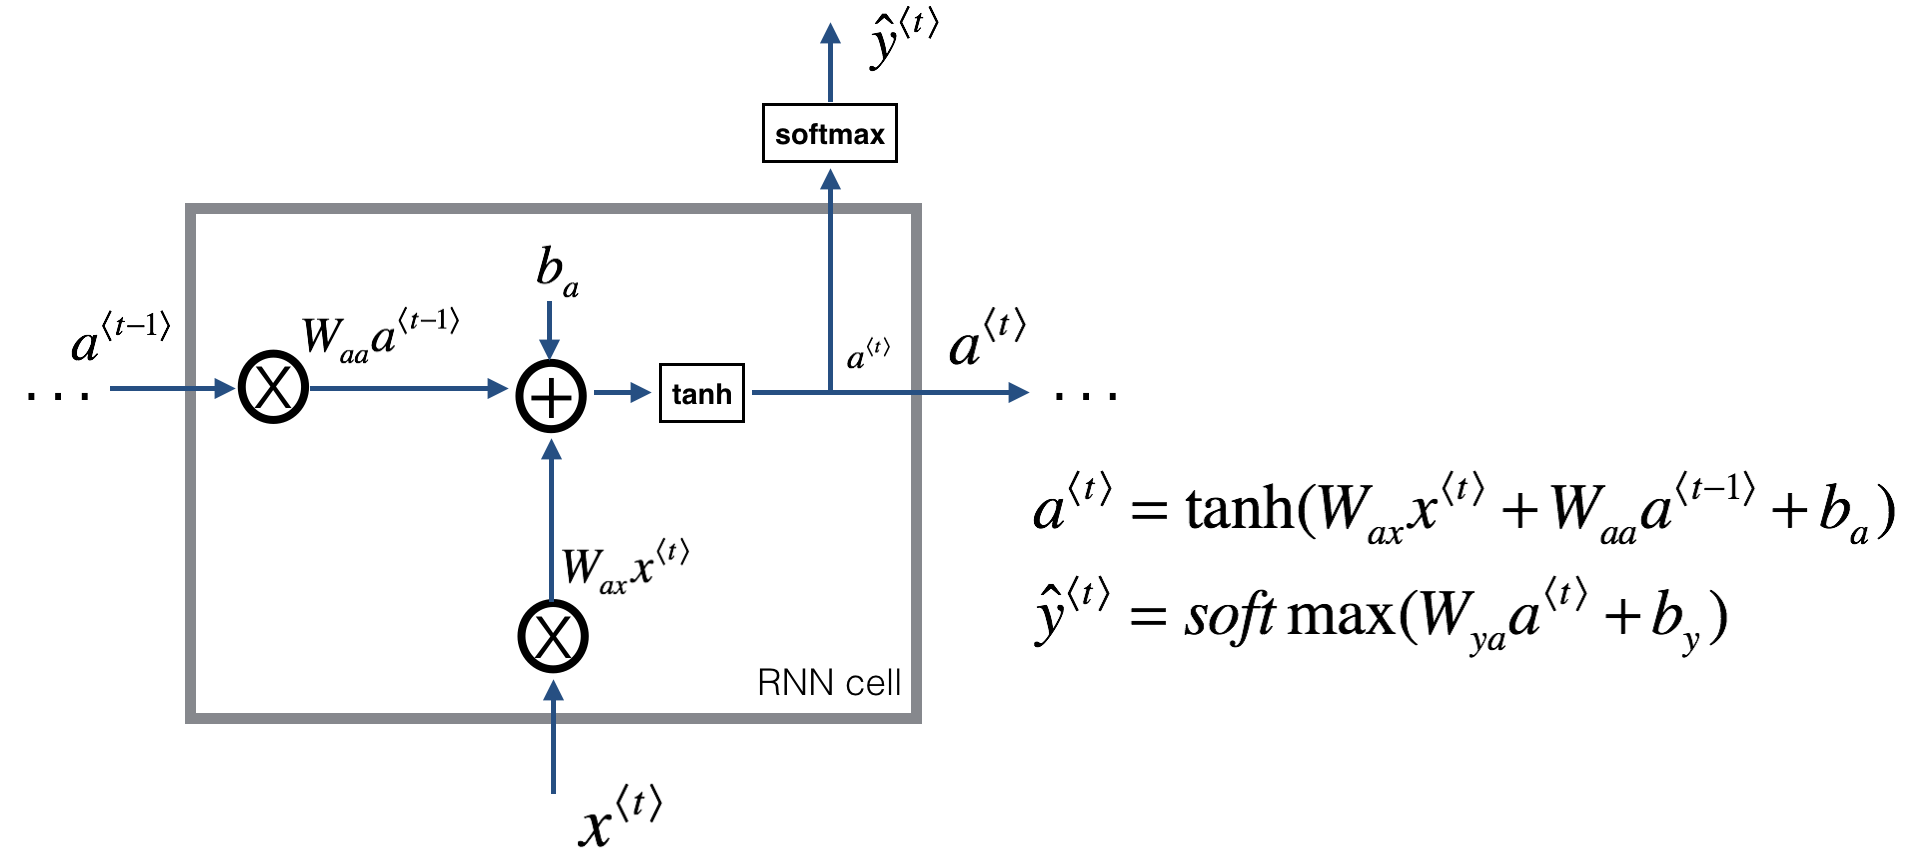

## Задание

Допишите модуль RNN по описанию выше.

Затем объявите `n_hidden = 128` и создайте ячейку RNN с гиперпараметрами `n_letters, n_hidden, n_categories`. Назовите ее `rnn`.

Сколько признаков поступает в первый линейный слой `rnn`?

In [116]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()


        # self.input_size = input_size
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # shape 57+128=(185, 128)
        self.h2o = nn.Linear(hidden_size, output_size) # shape (128, 18)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1) # конкатенируем векторы input и hidden и далее подаем в сеть

        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [117]:
print(n_letters, n_hidden, n_categories)

57 128 18


In [118]:
print(rnn)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


## Задание

В нашу `rnn`-ячейку нужно передавать входной символ и предыдущее скрытое состояние. На первом шаге скрытое состояние - это вектор из нулей.

Допишите код, который передает в RNN букву 'D' и выведите на экран цифру (без знака), на которую начинается большинство координат вектора-прогноза (`output`).

P.S. Не забудьте перевести букву в тензор нужного формата, используя написанную выше функцию `letterToTensor`.

In [119]:
input = letterToTensor('D')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [109]:
input.shape

torch.Size([1, 57])

In [120]:
output

tensor([[-2.8933, -2.8810, -2.8256, -2.9914, -2.7916, -2.9310, -2.9420, -2.8459,
         -2.8128, -2.9437, -2.7894, -2.9316, -2.8790, -2.8640, -2.8570, -2.9430,
         -2.9505, -2.9887]], grad_fn=<LogSoftmaxBackward0>)

Когда мы будем работать с именами, то будем переводить в тензор сразу все имя. Это можно сделать, используя код ниже.

In [121]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9709, -2.8805, -2.8441, -2.8973, -2.8102, -2.9454, -2.9527, -2.8638,
         -2.8644, -2.8996, -2.8171, -2.9257, -2.9247, -2.8221, -2.8276, -2.9750,
         -2.8822, -2.9487]], grad_fn=<LogSoftmaxBackward0>)


In [102]:
input.shape

torch.Size([6, 1, 57])

In [110]:
input[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])

In [84]:
output.size()

torch.Size([1, 18])

## Обучение

Перед тем как приступить к обучению, нам необходимо создать вспомогательные функции.

`categoryFromOutput` - функция, переводящая прогноз модели (набор вероятностей) в класс, то есть, возвращающая название языка и его номер.



In [122]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Czech', 4)


Функция `randomTrainingExample` выдает случайный язык из данных и имя из этого языка.

In [123]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line, category_tensor.size(), line_tensor.size(), line_tensor)

category = French / line = Lemieux torch.Size([1]) torch.Size([7, 1, 57]) tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0

### Обучение сети.

Мы будем использовать `NLLLoss` (negative log-likelihood loss). Объявите его.



In [124]:
criterion = nn.NLLLoss()

## Задание

Допишите функцию обучения сети по подсказкам в коде ниже.

In [127]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden() # инициализируйте веса сети rnn, используя метод init_hidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden) # на каждой итерации передавайте в сеть очередное слово (с индексом i) и скрытое состояние сети

    loss = criterion(output, category_tensor) # вычислите loss
    loss.backward() # вычислите градиенты методом обратного распространения ошибки

    # делаем шаг градиентного спуска
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Запустите код ниже. Если функция `train` написана корректно, то код отработает без ошибок.

Сколько строк напечатано на экране в результате работы кода?

In [128]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss


    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.4239 Fabron / French ✓
10000 10% (0m 13s) 2.1218 Awetisyan / Scottish ✗ (Russian)
15000 15% (0m 19s) 0.4584 Bukoski / Polish ✓
20000 20% (0m 25s) 1.0477 Filipek / Polish ✓
25000 25% (0m 32s) 0.3861 Kawaguchi / Japanese ✓
30000 30% (0m 38s) 0.4858 Ruadhain / Irish ✓
35000 35% (0m 45s) 1.1272 Abreu / Portuguese ✓
40000 40% (0m 51s) 0.6831 Rooiakkers / Dutch ✓
45000 45% (0m 58s) 0.0217 Bagachev / Russian ✓
50000 50% (1m 4s) 1.7415 Steuben / Dutch ✗ (German)
55000 55% (1m 11s) 5.0611 Steinborn / Dutch ✗ (Czech)
60000 60% (1m 17s) 0.3627 Sheng / Chinese ✓
65000 65% (1m 25s) 0.3502 Sadowski / Polish ✓
70000 70% (1m 31s) 0.7664 Cremonesi / Italian ✓
75000 75% (1m 38s) 0.9243 Sugita / Japanese ✓
80000 80% (1m 45s) 1.0977 Vasin / Russian ✓
85000 85% (1m 52s) 1.7657 Kanne / Irish ✗ (Dutch)
90000 90% (1m 58s) 3.0170 Germain / Irish ✗ (French)
95000 95% (2m 5s) 3.1877 Adam / Arabic ✗ (Irish)
100000 100% (2m 11s) 0.3392 Perez / Spanish ✓


## Задание (отрисовка результатов)

Нарисуйте график лосса, используя список `all_losses`.
Как ведет себя график?


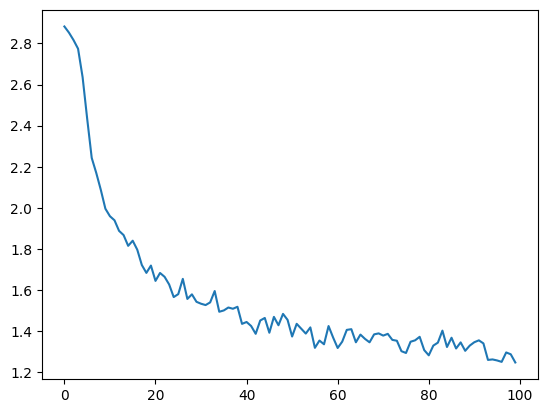

In [129]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Оценка качества модели

Функция `evaluate` - возвращает прогноз модели на конкретном слове (переведенном в тензор).


In [130]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

## Задание

Допишите цикл применения модели по комментариям в коде ниже.

Какой из языков классифицируется моделью лучше всего?

<ipython-input-131-9ab8224254ac>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-131-9ab8224254ac>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


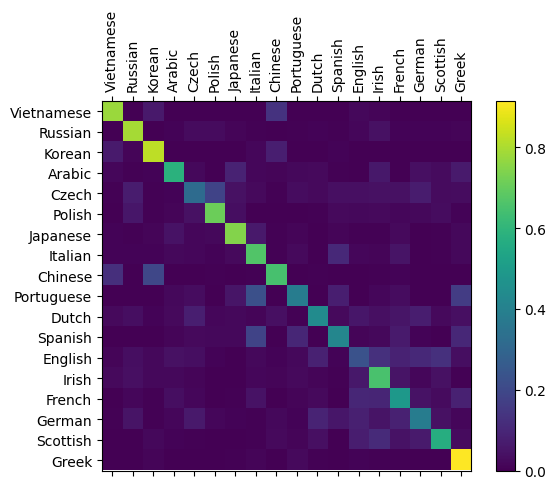

In [131]:
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor) # примените модель к line_tensor
    guess, guess_i = categoryFromOutput(output) # переведите прогноз в класс, используя функцию categoryFromOutput
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Нормализуем матрицу оценок
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Рисуем матрицу
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

### Запуск модели на новых именах (введенных пользователем)




In [132]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

## Задание

Запустите модель на своем имени, записанном транслитом. Правильно ли модель справилась с определением происхождения вашего имени?

In [135]:
predict('Maxim')
predict('Maksim')


> Maxim
(-0.51) Korean
(-2.63) Scottish
(-2.80) Irish

> Maksim
(-0.88) Russian
(-1.31) Scottish
(-2.41) Arabic
